---

# CSCI 3202, Fall 2022
# Homework 2: MDP & Reinforcement Learning
# Due: Friday September 9, 2022 at 6:00 PM

<br> 

### Your name:

<br> 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. 
* In this world, $L$ is always an even value.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
How many states would be in the discrete state space if $L=2$? Explain your reasoning.

Final States: 1 (landing pad)

Terminal (non-final) States: 8 (9 states with z=0, 1 is final)

Non-Terminal States: 18 (all states with z=1, z=2) 

Total States: 27

#### Part B
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to include transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part C, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
class MDPLanding:
    def __init__(self, L):
        self.L = L
        self.states = {}
        nums = range(L+1)
        ind = 0
        for i in nums:
            for j in nums:
                for k in nums:
                    self.states[(nums[i], nums[j], nums[k])] = ind
                    ind += 1

        self.terminal_states = {}
        for tup in self.states:
            if tup[2] == 0 and tup[0] ==  L/2 and tup[1] ==  L/2:
                self.terminal_states[tup] = 1
            elif tup[2] == 0:
                self.terminal_states[tup] = -1
                
        self.default_reward = -0.01
        self.all_actions = {'Up': 0, 'Down': 1, 'North': 2, 'South': 3, 'East': 4, 'West': 5}
        self.discount = 0.999
        
    def actions(self, state):
        actions = list(self.all_actions.keys()).copy()
        
        def doRemoval(num, rem1, rem2):
            if num == self.L:
                actions.remove(rem1)
            elif num == 0:
                actions.remove(rem2)
        
        doRemoval(state[0], 'East', 'West')
        doRemoval(state[1], 'North', 'South')
        doRemoval(state[2], 'Up', 'Down')
        
        return actions

    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.default_reward
    
    def result(self, state, action):
        if action in self.actions(state):
            if action == 'East':
                return (state[0]+1, state[1], state[2])
            elif action == 'West':
                return (state[0]-1, state[1], state[2])
            elif action == 'North':
                return (state[0], state[1]+1, state[2])
            elif action == 'South':
                return (state[0], state[1]-1, state[2])
            elif action == 'Up':
                return (state[0], state[1], state[2]+1)
            elif action == 'Down':
                return (state[0], state[1], state[2]-1)
        return state

In [3]:
# Test Cases:
l = MDPLanding(2)
print(l.actions((0,0,0)))
print(l.actions((1,1,0)))
print(l.actions((1,1,1)))
print(l.actions((2,2,2)))
print(l.result((2,2,2), 'South'))
print(l.result((2,2,2), 'North'))
print(l.result((0,0,0), 'Down'))
print(l.result((0,0,0), 'East'))

['Up', 'North', 'East']
['Up', 'North', 'South', 'East', 'West']
['Up', 'Down', 'North', 'South', 'East', 'West']
['Down', 'South', 'West']
(2, 1, 2)
(2, 2, 2)
(0, 0, 0)
(1, 0, 0)


#### Part C
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case.

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [4]:
L = 4
l = MDPLanding(L)

# Scoring based off distance to final state
def sqDiff(x1, x2):
    return (x2-x1)**2
        
def scoreState(state):
    pad = (L/2, L/2, 0)
    dist = np.sqrt((sqDiff(pad[0], state[0])
                    +sqDiff(pad[1], state[1])
                    +sqDiff(pad[2], state[2])))
    return dist

# Scoring based off utility
# def scoreState(a, s, U, l):
#     return sum([p * U[s1] for (p, s1) in l.result(s, a)])
    
# Find policy which gets us closest to final state
for tup in [(2,2,1),(0,2,1),(2,0,1)]:
    best_action = (None, 100)
    for action in l.actions(tup):
        if (nScore := scoreState(l.result(tup, action))) < best_action[1]:
            best_action = (action, nScore)
    print('The best policy from state', tup, 'is', best_action[0])
        

The best policy from state (2, 2, 1) is Down
The best policy from state (0, 2, 1) is East
The best policy from state (2, 0, 1) is North


The best policy from (2,2,1) should be down, becuase that puts you on the landing pad. \
The best policy from (0,2,1) should be east or down, becuase either puts you at 2 moves from the pad. \
The best policy from (2,0,1) should be north or down, becuase either puts you at 2 moves from the pad. \
My policy chooses the last tested best direction. Score is based on distance from the resulting state \
to the landing pad. So IE if east and down both score 1.5, whichever is tested second will be chosen, \
since there is no functional differene between them.


#### Part D
Provide an example of a non-deterministic transition that could be included in your code in Part C. Describe the function. How would you modify your code to handle a non-deterministic transition function?

A non-deterministic transition would be a transition that is not explicitly defined. \
This could be something simple like a random movement. To add this, I would add a \
chance to make a random move instead of the 'best' move.

#### Part E
Describe the main differences between **policy iteration** and **value iteration**? How would your code change in Part C to convert it to **value iteration**?

In value iteration, you through each state and each action, updating the utility for each \
state based off the expected utility of the state, which is determined through the \
utility of the following states and their probabilities.

#### Part F

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [5]:
'''
    l : the drone
    trials : num trials to run
    steps : max steps per trial
    alpha : learning rate
    epsilon : chance to explore
'''
def runTrials(Q, l, trials, steps=50, alpha=0.25, epsilon=0.25, 
              discount = 0.999):
    rewards = [0]*trials

    def getQ(Q, l, state, action):
        qCurrent = Q[l.states[state]][l.all_actions[action]]
        next_state = l.result(state, action)
        reward = l.reward(next_state)
        qMax = -1
        for inner_action in l.all_actions:
            val = Q[l.states[next_state]][l.all_actions[inner_action]]
            if val > qMax:
                qMax = val
        return (qCurrent + alpha * (reward + discount * qMax - qCurrent))
    '''
    Implemtation of Qnew algorithm from wikipedia
    
    Params:
        Q: current Q matrix
        l: drone
        state: current state
        action: action to take (direction)
    Returns: q of the state resulting from action
    '''
    
    for i in range(trials):
        # Choose random non-terminal starting location
        non_terminals = [x for x in l.states if x not in l.terminal_states]
        state = non_terminals[np.random.randint(0, len(non_terminals))]
        trial_reward = 0
        for j in range(steps):
            if state in l.terminal_states:
                break
            
            action = None
            possible_actions = l.actions(state)
            # Decide wether to Explore or Exploit
            if np.random.uniform() < epsilon:
                # Explore (pick random action)
                action = possible_actions[np.random.randint(len(possible_actions))]
            else:
                # Exploit (pick best action)
                best = (-1000, None)
                for it_action in possible_actions:
                    q = getQ(Q, l, state, it_action)
                    if q > best[0]:
                        best = (q, it_action)
                action = best[1]
            # Update Q & reward based off chosen action
            Q[l.states[state]][l.all_actions[action]] = getQ(Q, l, state, action) 
            next_state = l.result(state, action)
            trial_reward += l.reward(next_state)
            # Update state
            state = next_state
        # Cache cumulative reward for each trial
        rewards[i] = trial_reward

# Option to print full Q and rewards
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#         print(Q)
#     print("Reward:\n", rewards)
    
    return Q, rewards

In [6]:
# Testing/Profiling

# Setup World Space with L=4
# L = 4
# l = MDPLanding(L)

# Run 100 trials on the drone
# num_trials = 100

# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()
# Q, rewards = runTrials(l, num_trials)
# print(Q, rewards)
# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('cumtime')
# stats.print_stats()

# cProfile.run('runTrials(l, num_trials)')

# Q, rewards = runTrials(l, num_trials)

# print(rewards)
# print(np.mean(rewards))

Notes:
 * Terminal states should have value of their reward (in Q)?
   * By end or set in beginning?
   * src wikipedia
 * Difference between alpha and epsilon
   * Alpha used as 'learning rate' in Qnew
   * Epsilon used to determine explore vs exploit
     * Lower values are more accurate but take longer to find solution?
   * Should these be the same?

#### Part G

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

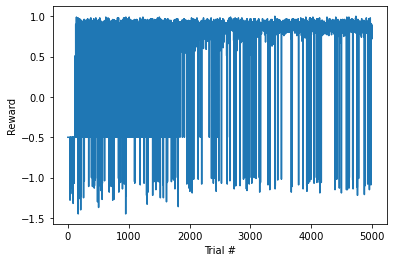

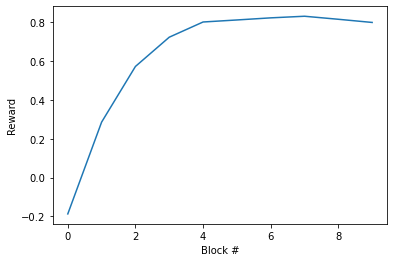

Mean of all rewards: 0.6276299999999999
Mean of last 50% of rewards 0.8161959999999999
Block Means: [-0.18752000000000013, 0.28557999999999995, 0.57244, 0.72324, 0.80158, 0.81202, 0.8229, 0.8312200000000001, 0.81558, 0.79926]
                    Up      Down     North     South      East      West
(0, 0, 0)     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
(0, 0, 1)    -0.005695  0.000000 -0.002300  0.000000 -0.004942  0.000000
(0, 0, 2)    -0.006513 -0.006513 -0.006513  0.000000 -0.005923  0.000000
(0, 0, 3)    -0.006513 -0.006126 -0.006126  0.000000  0.037736  0.000000
(0, 0, 4)    -0.006513 -0.006862 -0.006513  0.000000  0.001052  0.000000
(0, 0, 5)    -0.007176 -0.007176 -0.007176  0.000000 -0.006862  0.000000
(0, 0, 6)    -0.007712 -0.007712 -0.007941  0.000000 -0.003420  0.000000
(0, 0, 7)    -0.008332 -0.008332 -0.008332  0.000000 -0.008147  0.000000
(0, 0, 8)    -0.008649 -0.008649 -0.008649  0.000000 -0.008649  0.000000
(0, 0, 9)    -0.008906 -0.008784 -0.008784  

In [7]:
# Setup World Space with L=10
L = 10
l = MDPLanding(L)

Q = np.zeros((len(l.states), len(l.all_actions)))

# Run 5000 trials on the drone (10 blocks of 500)
blocks = 10
trials = 500

x = []
means = []
block_means = []

for i in range(blocks):
    Q, rewards = runTrials(Q, l, trials, alpha=0.1, epsilon=0.1)
    x.extend(list(np.linspace(i*trials, (i+1)*trials-1, trials)))
    means.extend(rewards)
    block_means.append(np.mean(rewards))

# Show plots and data
plt.plot(x, means)
plt.xlabel("Trial #")
plt.ylabel("Reward")
plt.show()

plt.plot(range(blocks), block_means)
plt.xlabel("Block #")
plt.ylabel("Reward")
plt.show()

print("Mean of all rewards:", np.mean(means))
print("Mean of last 50% of rewards", np.mean(means[len(means)//2:]))
# Means of block means are same as means of whole rewards
# print("Mean of all blocks:", np.mean(block_means))
# print("Mean of last 50% of blocks", np.mean(block_means[len(block_means)//2:]))
print("Block Means:", block_means)

# Display Q in a DataFrame so its readable, looks nice
df = pd.DataFrame(Q, columns=l.all_actions, index=list(l.states.keys()))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

#### Part H

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

**Your answer here:**



The reward starts off around -0.5 in the beginning because the drone doesnt have \
enough information about where to go. There is not enough information in Q for the \
drone to make a rational decision, so it is essentially acting randomly \
because it doesn't yet know the rewards of the states it wishes to travel to.

It will be difficult to reliably train a drone to reliably obtain rewards greater \
than 0.8 because of the learning rate. There must be a chance for the drone to \
explore so it can build data. This chance to explore is always possible when the \
drone is one step away from a terminal state. If the drone chooses to explore, and \
the random direction takes it to a non-final terminal state, the drone will fail.
